
Nineth exercice: non-Cartesian MR image reconstruction
=============================================
In this tutorial we will reconstruct an MRI image from radial undersampled kspace measurements. Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.

Import neuroimaging data
--------------------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice and the radial under-sampling scheme. We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.

We remind that the synthesis formulation reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - F_\Omega  \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - F_\Omega x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021 
- Target: ATSI MSc students, Paris-Saclay University

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.10/site-packages/pysap/extensions/transform.py:41: UserWarning: Sparse2D Python bindings not found. Any call to a Sparse2D transform or a plug-in method that uses a Sparse2D transform will result in an error.
  warnings.warn(


Loading input data
---------------------------

In [2]:
image = get_sample_data('2d-mri').data.astype(np.complex64)

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data

[====================] 100% example_mri_ref_image_2d.npy            
Download was done in 0 minutes,  1.55 seconds
[====================] 100% samples_radial_GA_nc64_ns512.npy        
Download was done in 0 minutes,  1.08 seconds


View Input data
------------------

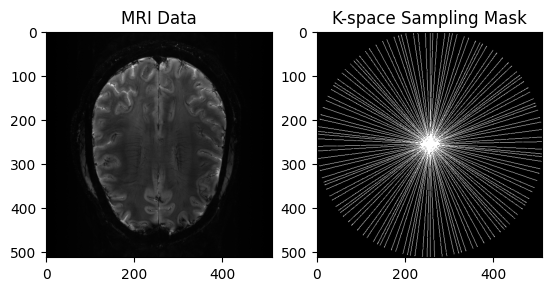

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(convert_locations_to_mask(kspace_loc, image.shape), cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a radial mask. We then reconstruct the zero-order solution as a baseline

Get the locations of the kspace samples

In [4]:
# Get the locations of the kspace samples and the associated observations
#fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape, implementation='gpuNUFFT
#kspace_obs = fourier_op.op(image)[0]
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape, implementation='finufft')
kspace_obs = fourier_op.op(image)

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:36: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(


Gridded solution

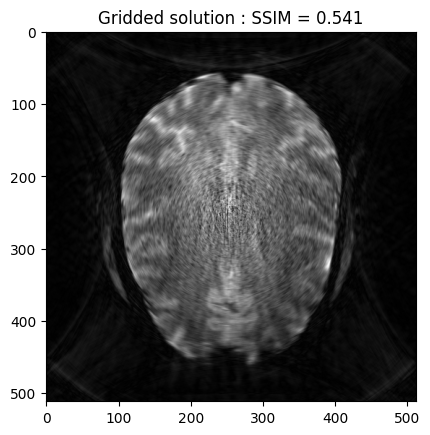

In [6]:
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
base_ssim = ssim(grid_soln, image)
plt.imshow(np.abs(grid_soln), cmap='gray')
plt.title('Gridded solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [7]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 6 * 1e-7, thresh_type="soft")

# Generate operators

In [8]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 17.828099441528323
The lipschitz constraint is satisfied


Synthesis formulation: FISTA optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [ ]:
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)

recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('FISTA Reconstruction : SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

 - mu:  6e-07
 - lipschitz constant:  17.828099441528323
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fc59fb77f40> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

## POGM reconstruction

In [ ]:
image_rec2, costs2, metrics2 = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='pogm',
    num_iterations=200,
)

recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('POGM Reconstruction : SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()

 - mu:  6e-07
 - lipschitz constant:  17.828097343444824
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fbc602467d0> - 4
 - max iterations:  200
 - image variable shape:  (1, 512, 512)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [13]:
#linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [14]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 570.452258225419
The lipschitz constraint is satisfied


 - mu:  6e-07
 - lipschitz constant:  570.452258225419
 - tau:  0.003499650305671012
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7fd8c528ba90> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:03:28 Time:  0:03:28


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  210.95389512297697  seconds
----------------------------------------


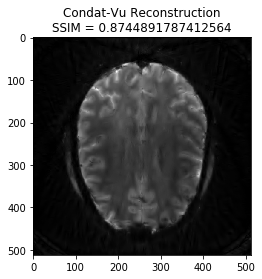

In [15]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
